# Query Statistics Visualization and Processing

The workload generation requires information about query runtimes. This notebook can be used to collect, combine, and visualize this information.

## Imports and Definitions

In [1]:
DIR_QUERIES = '../data/query-stats'
DIR_QUERIES_1 = f'{DIR_QUERIES}/1'
DIR_QUERIES_3 = f'{DIR_QUERIES}/3'
DIR_QUERIES_6 = f'{DIR_QUERIES}/6'
DIR_QUERIES_12 = f'{DIR_QUERIES}/12'
FILE_COMBINED_3 = f'{DIR_QUERIES}/3.csv'

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
RANGE_TO_DAYS = {
    "d_date = cast('2000-04-30' as date)": 1,
    "d_date between cast('2000-04-30' as date) and ((cast('2000-04-30' as date) + interval '6' week))": 7,
    "d_date between cast('2000-04-30' as date) and ((cast('2000-04-30' as date) + interval '2' week))": 14,
    "d_year = 2000 and d_moy = 1": 31,
    "d_year = 2000 and d_moy between 1 and 2": 60,
    "d_year = 2000 and d_moy between 1 and 3": 91,
    "d_year = 2000 and d_moy between 1 and 4": 121,
    "d_year = 2000 and d_moy between 1 and 5": 152,
    "d_year = 2000 and d_moy between 1 and 6": 182,
    "d_year = 2000 and d_moy between 1 and 7": 213,
    "d_year = 2000 and d_moy between 1 and 8": 244,
    "d_year = 2000 and d_moy between 1 and 9": 274,
    "d_year = 2000 and d_moy between 1 and 10": 305,
    "d_year = 2000 and d_moy between 1 and 11": 335,
    "d_year = 2000": 366,
    # "d_year = 2000 or (d_year = 2001 and d_moy between 1 and 6)": 547,
    # "d_year = 2000 or d_year = 2001": 731,
}


In [4]:
def get_combined_stats(dir):

    """
    Collect all query stats from the given directory and combine them into a single data frame, using the filename as the query name.
    """

    file_list = os.listdir(dir)

    df = pd.DataFrame()

    for file_name in file_list:
        if file_name.endswith('.csv'):
            df_query = pd.read_csv(f'{dir}/{file_name}')
            df_query['query'] = file_name.strip('.csv')
            df = pd.concat([df, df_query], ignore_index=True)

    return df.sort_values(['query', 'time'])

def save_combined_stats(queries, path):

    """
    Take a data frame of query stats and save it at the given path. 
    Multiple entries for the same query and range are combined into a single row with minimum, mean, and maximum durations. 
    Row counts for all entries with the same query and range are assumed to be equal, so the median value is taken in the aggregation.
    """

    query_times = queries[(queries['rows'] > 0) & (queries['range'] != 'FALSE')].groupby(['query', 'range']).agg({'time': ['mean', 'min', 'max'], 'rows': 'median'})
    query_times.columns = [c[0] + "_" + c[1] for c in query_times.columns]
    query_times = query_times.rename(columns={'rows_median': 'rows', 'time_mean': 'duration', 'time_min': 'min_duration', 'time_max': 'max_duration'})
    query_times['rows'] = query_times['rows'].astype(int)
    
    query_times.to_csv(path)

def get_mapped_df(queries):

    """
    Take a data frame of query stats and return an new version where the textual date range is also expressed as an integer representing the number of days. 
    Additionally add a column for time in seconds.
    """

    df = queries[queries['range'].isin(RANGE_TO_DAYS.keys())].copy()
    df['time_s'] = df['time'] / 1000
    df['range_days'] = df['range'].map(RANGE_TO_DAYS)
    return df

def add_plot(ax, queries, query_name, label, scatter=True, boxplot=False):

    """
    Filter the given data frame for the indicated query and add a scatter and/or boxplot of the resulting data to the given axis.
    """

    queries = queries[queries['query'] == query_name]

    x = queries['range_days']
    y = queries['time_s']

    if scatter:
        ax.scatter(x, y, alpha=0.25, s=10, label=label)

    if boxplot:
        grouped = queries.groupby(['range_days', 'query'])
        boxplot_data = []
        positions=[]

        for group, data in grouped:
            positions.append(data['range_days'].min())
            boxplot_data.append(data['time_s'])
        
        if len(positions) > 0:
            ax.boxplot(boxplot_data, positions=positions, widths=5)

## Usage

Read query data and map each data frame to include integer ranges:

In [5]:
queries = {}

queries[1] = get_combined_stats(DIR_QUERIES_1)
queries[3] = get_combined_stats(DIR_QUERIES_3)
queries[6] = get_combined_stats(DIR_QUERIES_6)
queries[12] = get_combined_stats(DIR_QUERIES_12)

queries_mapped = {k: get_mapped_df(v) for k, v in queries.items()}

Visualize the data:

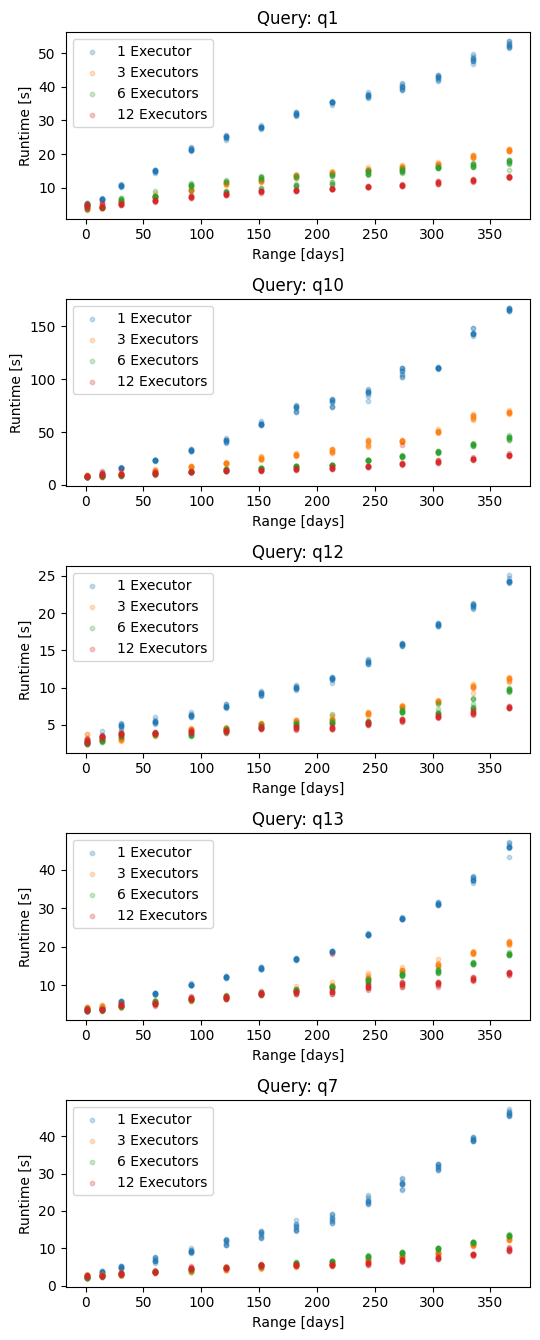

In [6]:
query_names = queries_mapped[3]['query'].unique()

fig, axs = plt.subplots(len(query_names), 1, figsize=(6, len(query_names) * 3))
fig.set_figwidth(5.5)
fig.set_figheight(2.7* len(axs))

for i, query in enumerate(query_names):

    for k, v in queries_mapped.items():
        add_plot(axs[i], v, query, f'{k} Executor{'s' if k > 1 else ''}', scatter=True)

    axs[i].legend()
    # print(f"R-squared value: {r2}")
    axs[i].set_xlabel('Range [days]')
    axs[i].set_ylabel('Runtime [s]')
    axs[i].set_title(f'Query: {query}')
    # axs[i].legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Save the needed/desired combined data to a file:

In [ ]:
save_combined_stats(queries[3], FILE_COMBINED_3)